# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import mlflow
import torch
import torch.nn.functional as F
import botorch
import gpytorch

from src import molecules
from src.selfies import SelfiesEncoder
from src.vae import MolecularVAE
from src.loss import VAELoss
from src.train import train_model, TrainingConfig

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [34]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9.csv"), index=False)

Add selfies encoding to raw data:

In [366]:
qm9_properties = ["alpha", "mu", "homo", "lumo", "gap", "r2", "zpve", "u0", "cv", "g298"]

In [4]:
df = pd.read_csv(os.path.join("data", "qm9.csv"))

df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df["logp"] = [molecules.penalized_logp(Chem.MolFromSmiles(s)) for s in df.smiles]

df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

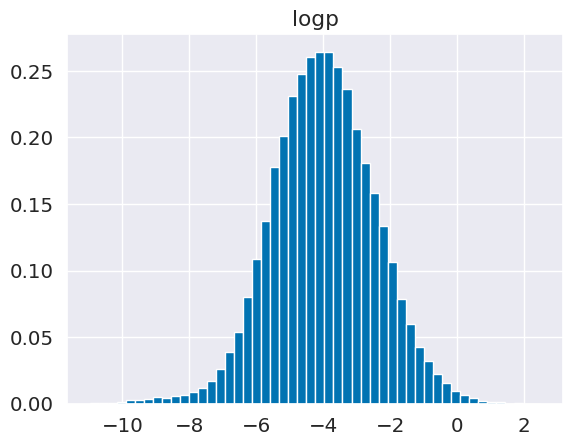

In [5]:
df.hist("logp", bins=50, density=True)
plt.show()

## Descriptors

In [367]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

In [368]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

sample_size = 1000
df_sample = df.sample(n=sample_size, random_state=12345)

In [369]:
excluded_names = ["MolLogP"]
available_names = [name for name, _ in Chem.Descriptors.descList if name not in excluded_names]

In [370]:
descriptors = molecules.get_rdkit_descriptors(df_sample.smiles, names=available_names)
targets = df_sample[qm9_properties]

In [11]:
n_train = int(sample_size/2)

x = StandardScaler().fit_transform(descriptors)
x_train = x[:n_train]
x_test = x[n_train:]

y_train = targets[:n_train]
y_test = targets[n_train:]

In [12]:
rf = RandomForestRegressor(random_state=12345)
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=12345))

In [13]:
mean_importances = np.mean([x.feature_importances_ for x in multi_rf.estimators_], axis=0)
mean_importances.shape

(208,)

In [14]:
n_features = [1, 2, 5, 10, 20, 40, 80, 160]
r2_vals = []
for nf in n_features:
    print(f"Evaluating model for n_features = {nf}")
    selected_support = mean_importances.argsort()[-nf:]
    x_train_selected = x_train[:, selected_support]
    x_test_selected = x_test[:, selected_support]

    # Use a new RF for each trial without a fixed seed
    estimator = MultiOutputRegressor(estimator=rf)
    estimator.fit(x_train_selected, y_train)
    y_hat = estimator.predict(x_test_selected)
    r2_vals.append(r2_score(y_test, y_hat))

Evaluating model for n_features = 1
Evaluating model for n_features = 2
Evaluating model for n_features = 5
Evaluating model for n_features = 10
Evaluating model for n_features = 20
Evaluating model for n_features = 40
Evaluating model for n_features = 80
Evaluating model for n_features = 160


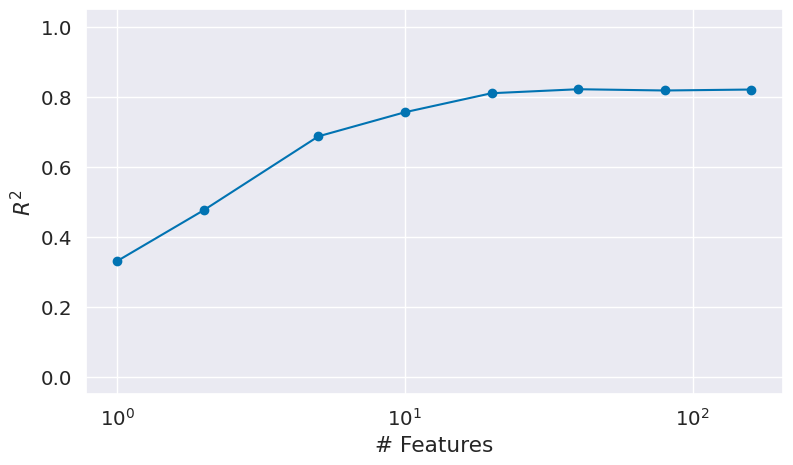

In [17]:
_, ax = plt.subplots(1, 1, figsize=(9, 5))

plt.plot(n_features, r2_vals, marker="o")

ax.set_xlabel("# Features")
ax.set_ylabel("$R^2$")
ax.set_ylim(-0.05, 1.05)
ax.set_xscale("log")

# plt.savefig("images/rdkit_feature_selection.png")
plt.show()

In [18]:
selected_indices = mean_importances.argsort()[-20:]
sorted([available_names[idx] for idx in selected_indices])

['BCUT2D_MRHI',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'FractionCSP3',
 'HallKierAlpha',
 'HeavyAtomMolWt',
 'Kappa1',
 'Kappa3',
 'LabuteASA',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MolMR',
 'NumRotatableBonds',
 'PEOE_VSA4',
 'TPSA',
 'VSA_EState2',
 'VSA_EState4',
 'VSA_EState5']

## Splits

In [363]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [364]:
inputs = []
for s in tqdm(selfies):
    inputs.append(selfies_encoder.encode_one_hot(s))
inputs = torch.tensor(inputs)

inputs.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:03<00:00, 36375.25it/s]


torch.Size([133885, 21, 29])

In [371]:
properties = df[qm9_properties].to_numpy()
properties = (properties - properties.mean(axis=0)) / properties.std(axis=0)
properties = torch.from_numpy(properties)

properties.shape

torch.Size([133885, 10])

In [87]:
logp_target = df["logp"].to_numpy()
logp_target = (logp_target - logp_target.mean(axis=0)) / logp_target.std(axis=0)
logp_target = torch.from_numpy(logp_target)
logp_target = logp_target.reshape(-1, 1)

logp_target.shape

torch.Size([133885, 1])

In [91]:
descriptor_names = [
    'BCUT2D_MRHI',
    'BertzCT',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'FractionCSP3',
    'HallKierAlpha',
    'HeavyAtomMolWt',
    'Kappa1',
    'Kappa3',
    'LabuteASA',
    'MaxPartialCharge',
    'MinPartialCharge',
    'MolMR',
    'NumRotatableBonds',
    'PEOE_VSA4',
    'TPSA',
    'VSA_EState2',
    'VSA_EState4',
    'VSA_EState5'
]

mols = [Chem.MolFromSmiles(s) for s in df.smiles]

rdkit_descriptors = molecules.get_rdkit_descriptors(mols, names=descriptor_names)
rdkit_descriptors = (rdkit_descriptors - rdkit_descriptors.mean(axis=0)) / rdkit_descriptors.std(axis=0)
rdkit_descriptors = torch.from_numpy(rdkit_descriptors)

rdkit_descriptors.shape

torch.Size([133885, 20])

Split the data and save:

In [374]:
gen = torch.manual_seed(42)

n = len(inputs)
test_size = 15000
val_size = 2000
train_size = n - test_size - val_size

random_indices = torch.randperm(n, generator=gen)
train_indices = random_indices[:train_size]
test_indices = random_indices[train_size:train_size+test_size]
val_indices = random_indices[train_size+test_size:]

tensors = [
    ("inputs", inputs), 
    ("descriptors", rdkit_descriptors), 
    ("properties", properties),
    ("logp", logp_target), 
]
for name, tensor in tensors:
    train_tensor = tensor[train_indices]
    test_tensor = tensor[test_indices]
    val_tensor = tensor[val_indices]

    torch.save(train_tensor, os.path.join("data", f"qm9_{name}_train.pt"))
    torch.save(test_tensor, os.path.join("data", f"qm9_{name}_test.pt"))
    torch.save(val_tensor, os.path.join("data", f"qm9_{name}_val.pt"))

# Molecular VAE

## Training

In [11]:
config = TrainingConfig(
    targets="logp",
    epochs=100,
    lr_init=2e-3,
    lr_gamma=0.5,
    lr_milestones=[10, 20, 30, 45, 60, 75],
    mse_scale=20.0,
    beta_max=1.0,
    beta_start=50,
    beta_end=75
)

config

TrainingConfig(targets='logp', epochs=100, latent_size=50, encoder_hidden_size=400, gru_hidden_size=500, mlp_hidden_size=300, gru_layers=3, gru_dropout=0.05, mse_scale=20.0, beta_max=1.0, beta_start=50, beta_end=75, batch_size=250, weight_decay=1e-05, lr_init=0.002, lr_gamma=0.5, lr_milestones=[10, 20, 30, 45, 60, 75])

In [12]:
train_model(config, run_name="logp_beta_1.0")

2023-08-22 19:09:46.016 | INFO     | src.train:train_model:123 - Using device cuda:0
2023-08-22 19:09:46.317 | INFO     | src.train:train_model:141 - Initialized model with 4033486 parameters
2023-08-22 19:10:04.262 | INFO     | src.train:train_model:175 - Epoch 1 | Train Loss 33.719 | Test Loss 26.042 | LR 2.000e-03
2023-08-22 19:10:21.880 | INFO     | src.train:train_model:175 - Epoch 2 | Train Loss 24.415 | Test Loss 22.873 | LR 2.000e-03
2023-08-22 19:10:39.479 | INFO     | src.train:train_model:175 - Epoch 3 | Train Loss 21.090 | Test Loss 18.025 | LR 2.000e-03
2023-08-22 19:10:57.433 | INFO     | src.train:train_model:175 - Epoch 4 | Train Loss 15.544 | Test Loss 13.123 | LR 2.000e-03
2023-08-22 19:11:14.945 | INFO     | src.train:train_model:175 - Epoch 5 | Train Loss 11.829 | Test Loss 10.248 | LR 2.000e-03
2023-08-22 19:11:33.089 | INFO     | src.train:train_model:175 - Epoch 6 | Train Loss 8.778 | Test Loss 8.407 | LR 2.000e-03
2023-08-22 19:11:50.815 | INFO     | src.train:t

## Analysis

In [48]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

inputs_val = torch.load(os.path.join("data", "qm9_inputs_val.pt")).float()
descriptors_val = torch.load(os.path.join("data", "qm9_descriptors_val.pt")).float()
properties_val = torch.load(os.path.join("data", "qm9_properties_val.pt")).float()
logp_val = torch.load(os.path.join("data", "qm9_logp_val.pt")).float()

all_selfies = set(df.selfies)
selfies_encoder = SelfiesEncoder.build(all_selfies)

In [49]:
experiment = mlflow.get_experiment_by_name("MolecularVAE")
runs = mlflow.search_runs(experiment.experiment_id)

vae_dict = {}
for _, row in runs.iterrows():
    run_id = row.run_id
    vae = mlflow.pytorch.load_model(f"runs:/{run_id}/model")
    vae_dict[row["tags.mlflow.runName"]] = vae

### Interpolation

In [50]:
selfies_val = [selfies_encoder.decode_tensor(x) for x in inputs_val]

selfies_val[760]

'[C][C][C][C][C][Branch1][Branch2][C][=C][C][Ring1][#Branch1][Ring1][Branch1][N][Ring1][Branch2][Ring1][#Branch1]'

In [52]:
start_selfie = '[C][#C][C][#C][C][C][=O]'
end_selfie = '[C][C][C][C][C][Branch1][Branch2][C][=C][C][Ring1][#Branch1][Ring1][Branch1][N][Ring1][Branch2][Ring1][#Branch1]'

start_x = torch.tensor(selfies_encoder.encode_one_hot(start_selfie), dtype=torch.float32)
end_x = torch.tensor(selfies_encoder.encode_one_hot(end_selfie), dtype=torch.float32)

interp_images = []
for name, vae in vae_dict.items():

    interp_x = vae.interpolate(start_x, end_x, 5)
    interp_x = interp_x

    interp_smiles = []
    for x in interp_x:
        selfie = selfies_encoder.decode_tensor(x)
        smile = sf.decoder(selfie)
        if smile not in interp_smiles:
            interp_smiles.append(smile)
    interp_mols = [Chem.MolFromSmiles(s) for s in interp_smiles]

    interp_images.append((name, Chem.Draw.MolsToGridImage(interp_mols, molsPerRow=5)))



Model: logp_beta_1.0


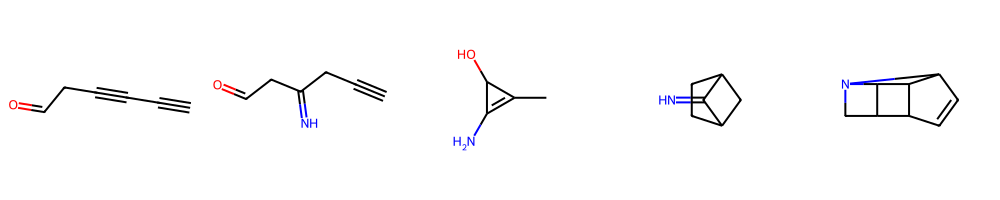

Model: logp_beta_0.01


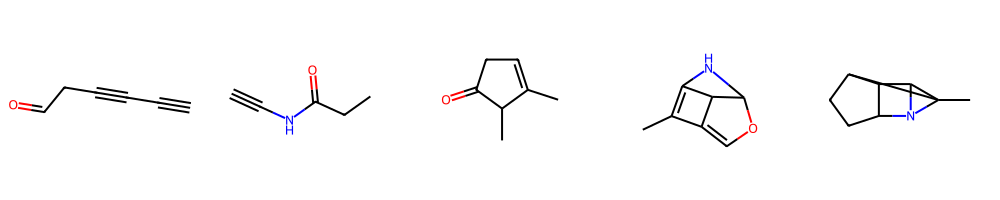

Model: properties_beta_0.1


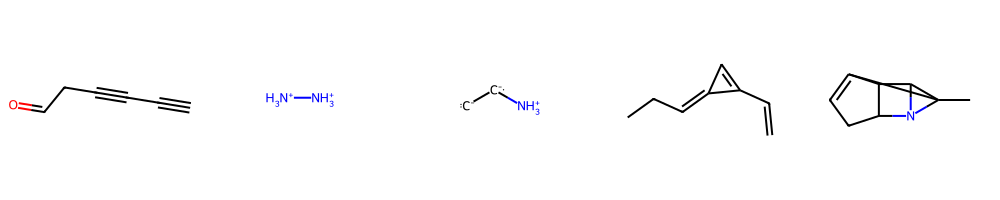

Model: logp_beta_0.1


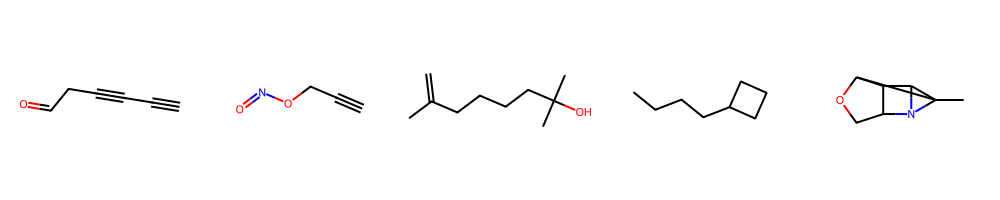

Model: no_mse_beta_0.1


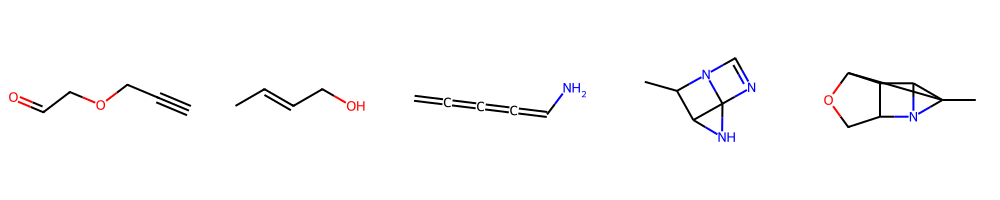

Model: properties_beta_0.01


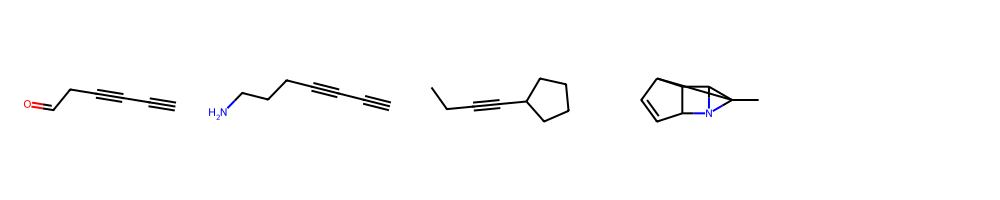

Model: descriptors_beta_0.1


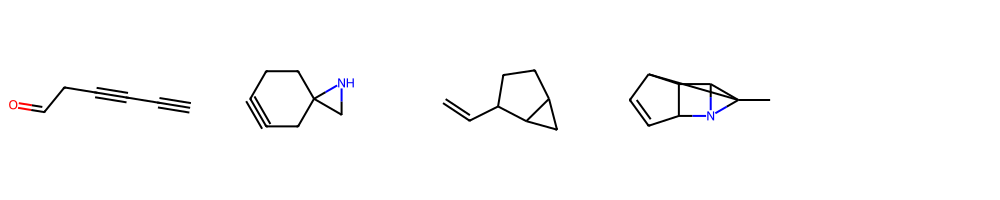

Model: descriptors_beta_0.01


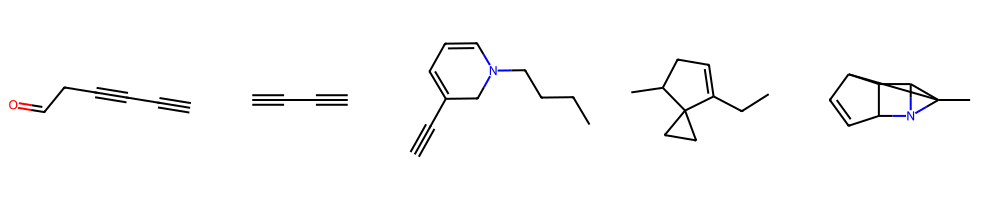

In [53]:
print("\n")
for name, img in interp_images:
    print(f"Model: {name}")
    display(img)

### Effect of KL Weight

In [15]:
def get_unique_fraction(vae, n=1000) -> float:
    draws = vae.sample(n)
    selfies = [selfies_encoder.decode_tensor(x) for x in draws]
    return len(set(selfies)) / n

def get_novel_fraction(vae, n=1000) -> float:
    draws = vae.sample(n)
    selfies = {selfies_encoder.decode_tensor(x) for x in draws}
    return len(selfies.difference(all_selfies)) / n

Working on beta = 0.01
Working on beta = 0.1
Working on beta = 1.0


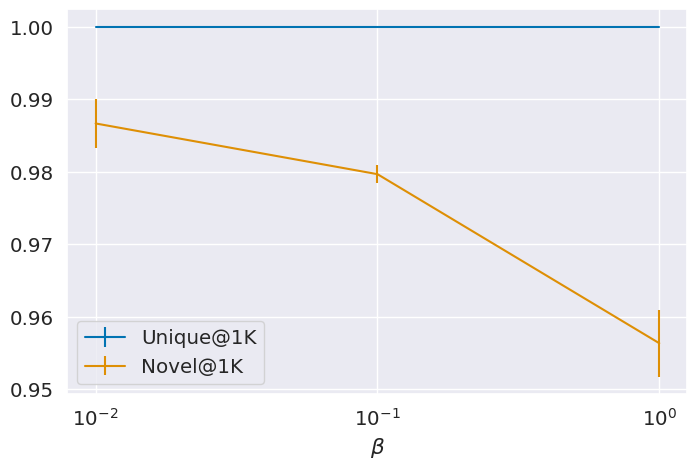

In [16]:
n_trials = 3
n_samples = 1000
betas = [0.01, 0.1, 1.0]

unique_means = []
unique_stds = []
novel_means = []
novel_stds = []
for beta in betas:
    print(f"Working on beta = {beta}")
    vae = vae_dict[f"logp_beta_{beta}"]

    unique = []
    novel = []
    for _ in range(n_trials):
        unique.append(get_unique_fraction(vae, n_samples))
        novel.append(get_novel_fraction(vae, n_samples))

    unique_means.append(np.mean(unique))
    unique_stds.append(np.std(unique))
    novel_means.append(np.mean(novel))
    novel_stds.append(np.std(novel))

_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.errorbar(betas, unique_means, yerr=unique_stds, label = f"Unique@1K")
ax.errorbar(betas, novel_means, yerr=novel_stds, label = f"Novel@1K")

plt.xlabel("$\\beta$")
plt.xscale("log")
plt.legend()

plt.show()

Working on beta = 0.01
Working on beta = 0.1
Working on beta = 1.0


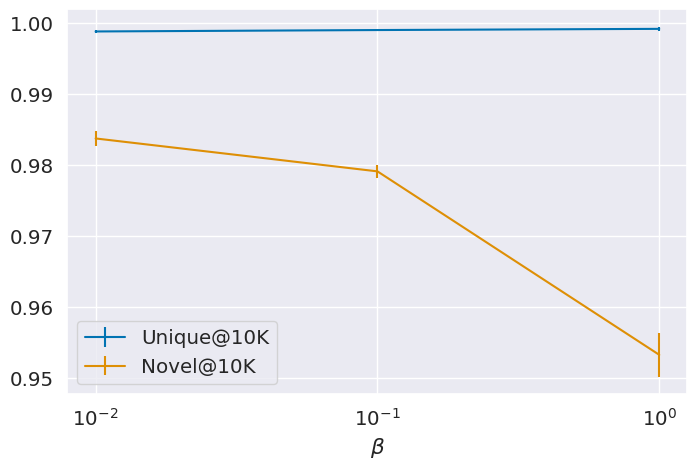

In [17]:
n_trials = 3
n_samples = 10000
betas = [0.01, 0.1, 1.0]

unique_means = []
unique_stds = []
novel_means = []
novel_stds = []
for beta in betas:
    print(f"Working on beta = {beta}")
    vae = vae_dict[f"logp_beta_{beta}"]

    unique = []
    novel = []
    for _ in range(n_trials):
        unique.append(get_unique_fraction(vae, n_samples))
        novel.append(get_novel_fraction(vae, n_samples))

    unique_means.append(np.mean(unique))
    unique_stds.append(np.std(unique))
    novel_means.append(np.mean(novel))
    novel_stds.append(np.std(novel))

_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.errorbar(betas, unique_means, yerr=unique_stds, label = f"Unique@10K")
ax.errorbar(betas, novel_means, yerr=novel_stds, label = f"Novel@10K")

plt.xlabel("$\\beta$")
plt.xscale("log")
plt.legend()

plt.show()

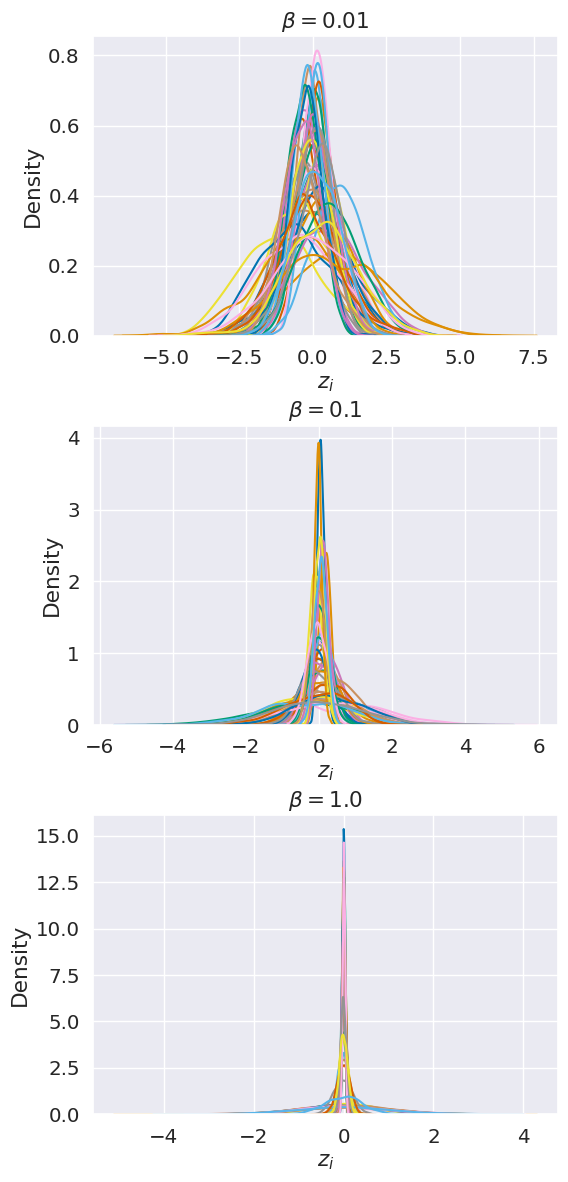

In [29]:
_, ax = plt.subplots(3, 1, figsize=(6, 14))

betas = [0.01, 0.1, 1.0]
for idx, beta in enumerate(betas):
    vae = vae_dict[f"logp_beta_{beta}"]

    means, _ = vae.encode(inputs_val)
    means = means.detach().numpy()
    for dim in range(means.shape[1]):
        sns.kdeplot(means[:, dim], ax=ax[idx])

    ax[idx].set_xlabel("$z_i$")
    ax[idx].title.set_text(f'$\\beta = {beta}$')

plt.subplots_adjust(hspace=0.3)
plt.show()

### Latent Separation

In [54]:
from sklearn.decomposition import PCA

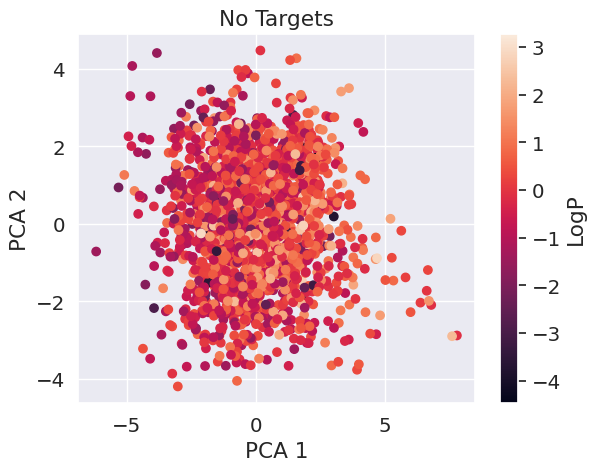

In [55]:
vae = vae_dict["no_mse_beta_0.1"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("No Targets")

plt.show()

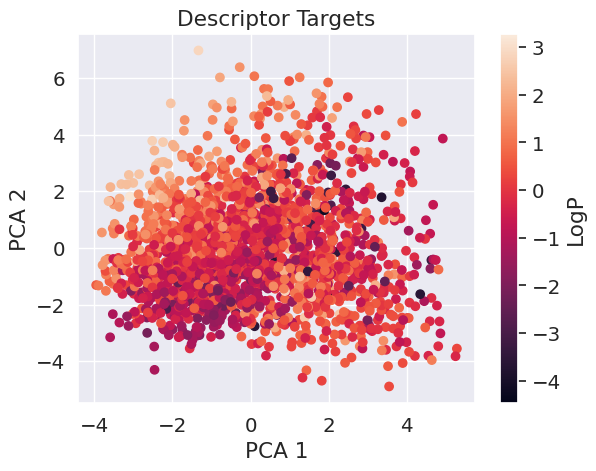

In [56]:
vae = vae_dict["descriptors_beta_0.1"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Descriptor Targets")


plt.show()

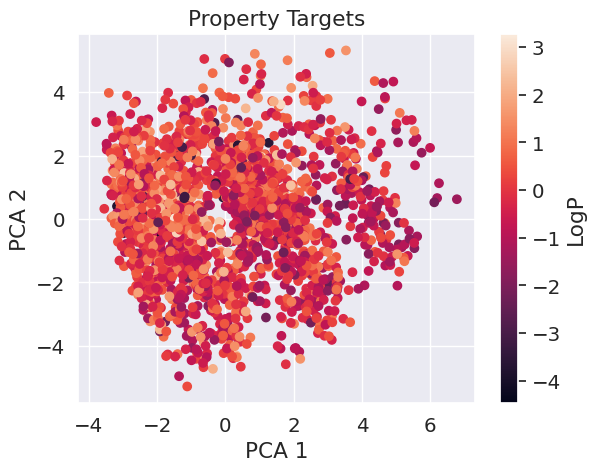

In [57]:
vae = vae_dict["properties_beta_0.1"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Property Targets")

plt.show()

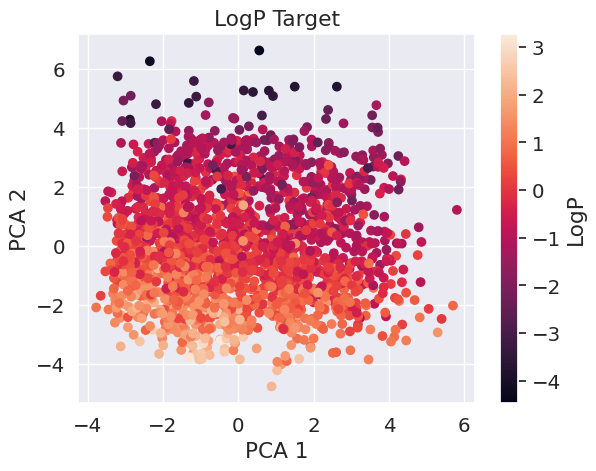

In [58]:
vae = vae_dict["logp_beta_0.1"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("LogP Target")

plt.show()

### Regression

In [79]:
from botorch.utils.transforms import normalize
from sklearn.metrics import r2_score

from src.optim import get_fitted_gp

In [80]:
def measure_surrogate_r2(vae, n_train):
    z = vae.encode(inputs_val)[0].detach().double()        
    y = logp_val.clone().double()

    z_train = z[:n_train]
    z_test = z[1500:]

    y_train = y[:n_train]
    y_test = y[1500:]

    bounds = torch.stack([z.min(dim=0).values, z.max(dim=0).values])
    gp = get_fitted_model(z_train, y_train, bounds)

    z_test_scaled = normalize(z_test, bounds)
    mvn = gp(z_test_scaled)
    y_pred_mean = mvn.mean.detach()
    return r2_score(y_test, y_pred_mean)

In [81]:
train_sizes = [50, 100, 200, 400, 600, 800, 1000]

test_vaes = {
    "LogP": vae_dict["logp_beta_0.1"],
    "Descriptors": vae_dict["descriptors_beta_0.1"],
    "Properties": vae_dict["properties_beta_0.1"]
}

r2_scores = {}
for name, vae in test_vaes.items():
    print(f"VAE = {name}")
    r2_scores[name] = []
    for n in train_sizes:
        r2 = measure_surrogate_r2(vae, n)
        r2_scores[name].append(r2)

VAE = LogP
VAE = Descriptors
VAE = Properties


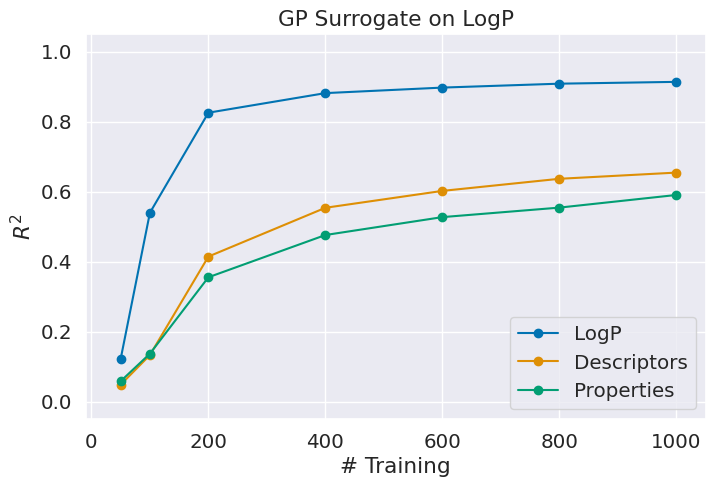

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

for name, scores in r2_scores.items():
    ax.plot(train_sizes, scores, label=name, marker="o")

ax.set_xlabel("# Training")
ax.set_ylabel("$R^2$")
ax.set_xlim(-10, 1050)
ax.set_ylim(-0.05, 1.05)

plt.legend(loc="lower right")
plt.title("GP Surrogate on LogP")

plt.show()

# Optimization

In [111]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

all_selfies = set(df.selfies)
selfies_encoder = SelfiesEncoder.build(all_selfies)

In [114]:
experiment = mlflow.get_experiment_by_name("MolecularVAE")
runs = mlflow.search_runs(experiment.experiment_id)

vae_dict = {}
for _, row in runs.iterrows():
    run_id = row.run_id
    vae = mlflow.pytorch.load_model(f"runs:/{run_id}/model")
    vae_dict[row["tags.mlflow.runName"]] = vae

## Single Molecule

In [250]:
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.acquisition import qExpectedImprovement

In [727]:
def evaluate_objective(z, vae, selfies_encoder):
    decodings = vae.decode(z)
    selfies = [selfies_encoder.decode_tensor(x) for x in decodings]
    mols = [Chem.MolFromSmiles(sf.decoder(s)) for s in selfies]
    logps = []
    for mol in mols:
        if mol.GetNumAtoms() == 0:
            obj = float("-inf")
        else:
            obj = molecules.penalized_logp(mol)
        logps.append(obj)
    return torch.tensor(logps).unsqueeze(-1)

def generate_initial_data(n, vae, selfies_encoder, gen=None):
    z = torch.randn(n, vae.latent_size, generator=gen)
    y = evaluate_objective(z, vae, selfies_encoder)
    return z, y

def optimize_and_evaluate(acqf, bounds, vae, selfies_encoder, *, batch_size=5, num_restarts=10, raw_samples=100):
    candidates, acqf_values = optimize_acqf(
        acq_function=acqf,
        bounds=torch.stack([torch.zeros(vae.latent_size), torch.ones(vae.latent_size)]),
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        return_best_only=True
    )
    new_z = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = evaluate_objective(new_z, vae, selfies_encoder)
    finite_obj = torch.isfinite(new_obj).squeeze()
    return new_z[finite_obj], new_obj[finite_obj]

In [728]:
vae = vae_dict["logp_beta_0.01"]

In [729]:
z_train, y_train = generate_initial_data(250, vae, selfies_encoder)

In [730]:
bounds = torch.stack([z_train.min(axis=0).values, z_train.max(axis=0).values])

In [731]:
gp = get_fitted_gp(z_train, y_train, bounds)

acqf = qExpectedImprovement(model=gp, best_f=y_train.max().item())

/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)


In [752]:
candidates, values = optimize_and_evaluate(acqf, bounds, vae, selfies_encoder, batch_size=5)

values

tensor([[-1.5590],
        [-1.2857],
        [-6.1684],
        [-2.6543],
        [-3.1948]])

In [753]:
candidate_selfies = [selfies_encoder.decode_tensor(x) for x in vae.decode(candidates)]
candidate_selfies

['[C][C][C][O][C][C][C][Ring1][C][C][Branch2][Ring1][Ring1][=Branch1][Ring1]',
 '[O][N][C][C][O][C][C][C][C][C][C][Ring1][Branch1]',
 '[C][#C][C][N][N][=C][C][=C][Ring2][C][Ring1][Ring1][C]',
 '[C][N][Branch1][C][C][C][C][C][Ring1][=Branch1][C][O]',
 '[C][C][C][=C][Branch1][C][C][C][C][N][C][Ring1][Branch2][Ring1]']

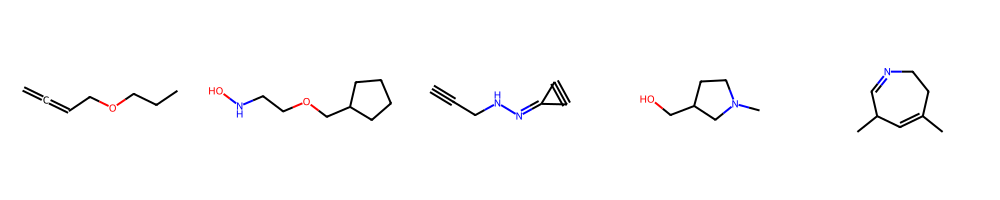

In [754]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(sf.decoder(s)) for s in candidate_selfies], molsPerRow=5)

## Mixture